In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements

In [2]:
# Different approach needed for this one as no obvious end point.
# Looks to have worked well. 

url='https://www.janestreet.com/puzzles/knight-moves-3/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:22]))

Place the numbers 1, 2,…, N (for some N ) on a subset of the squares below, so that it is possible for a knight to move from 1 to N via a series of legal knight’s moves. Each number inside the grid represents the height of a building located at that square, and we can think of the knight as jumping from rooftop to rooftop on this series of incrementally taller buildings. A number outside the grid indicates the first (i.e. smallest) number for which the knight was visible looking into the grid in the direction of that row or column. (As shown in the example.) The answer to this puzzle is the smallest achievable product of the areas of the connected groups of empty squares in the completed grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/08/20190805_knight_moves_3.png" width="350">

In [3]:
# Setup the constraints
top = np.array([0,29,19,33,20,27,36,35])
rhs = np.array([0,26,36,25,37,4,23,6])
bot = np.array([13,14,12,2,1,5,7,0])
lhs = np.array([18,19,30,10,16,11,12,0])

In [28]:
class Matrix():
    def __init__(self,top,rhs,bot,lhs):
        self.top = top
        self.rhs = rhs
        self.bot = bot
        self.lhs = lhs
        # knight moves
        self.x = [2, 1, -1, -2, -2, -1, 1, 2]
        self.y = [1, 2, 2, 1, -1, -2, -2, -1]

    ################################################
    # The big one .. check if a placement is allowed
    # by the looks. Does some of the filling in of cells too
    
    def not_possible(self,row,col,next_num,fixed):
        #check the looks for the outside columns
        if row == 0 and next_num != self.top[col] and self.top[col] != 0: 
            return True
        if col == 0 and next_num != self.lhs[row] and self.lhs[row] != 0: 
            return True
        if row == 7 and next_num != self.bot[col] and self.bot[col] != 0: 
            return True
        if col == 7 and next_num != self.rhs[row] and self.rhs[row] != 0: 
            return True

        # don't place a number that is in the looks in a different row/column 
        if next_num in self.top and col not in np.where(self.top ==next_num): 
            return True
        if next_num in self.rhs and row not in np.where(self.rhs ==next_num): 
            return True
        if next_num in self.bot and col not in np.where(self.bot ==next_num): 
            return True
        if next_num in self.lhs and row not in np.where(self.lhs ==next_num): 
            return True
    
        # put in zeros when a number in looks is placed and check the look
        if next_num in self.top:
            for i in range(0,row):
                if fixed[i,col] > 0: 
                    return True
                fixed[i,col] = 0
        if next_num in self.rhs:
            for i in range(col+1,8):
                if fixed[row,i] > 0: 
                    return True
                fixed[row,i] = 0
        if next_num in self.bot:
            for i in range(row+1,8):
                if fixed[i,col] > 0: 
                    return True
                fixed[i,col] = 0
        if next_num in self.lhs:
            for i in range(0,col):
                if fixed[row,i] > 0: 
                    return True
                fixed[row,i] = 0
        return False
        
    #########################################
    # 2 functions define the moves and do a 
    # final check
        
    def poss_moves(self,row,col):
        # return the possible moves for a given cell
        moves = []
        for i in range(8):
            new_row = row+self.x[i]
            new_col = col+self.y[i]

            if (new_row > -1) & (new_row <8) & (new_col > -1) & (new_col <8):
                moves.append([new_row,new_col])
        return moves          
        
    def final_check(self,grid):
        # check all the looks one last time
        for i in range(8):
            row = grid[i,:]
            col = grid[:,i]
            row = row[row>0]
            col = col[col>0]
        
            if len(row) > 0:
                if row[0]  != self.lhs[i] & self.lhs[i] != 0:
                    return False
                if row[-1] != self.rhs[i]& self.rhs[i] != 0:
                    return False
            
            if len(col) > 0:
                if col[0]  != self.top[i] & self.top[i] != 0:
                    return False
                if col[-1] != self.bot[i] & self.bot[i] != 0:
                    return False
        return True
   
    ##############################################
    # Two last functions
    # Get the products of the areas of the connected cells    
    # Loop through and print the grids
    def areas(self,grid):
        labels, num = measurements.label(grid<1)
        areas = measurements.sum(grid<1, labels, index=range(1, num+1))
        return  int(np.prod(areas))
    
    def sol_print(self,solved_grids,limit):      
        fig,ax = plt.subplots(1,3,figsize=(9,3))
        count = 0
        for solved in solved_grids:
            score, grid, high_num = solved
            if score != limit:
                continue
            x = np.array((grid).astype('int').astype('str'))
            x[x=="0"] ="-"
            x[x=="-1"] ="-"
            y = grid > 0
            ax[count] = sns.heatmap(grid,annot=x,cbar=False,cmap="Reds",fmt="",linewidths=1,center=75,linecolor="grey",ax=ax[count])
            ax[count].axis("off")
            plt.tight_layout()
            count += 1
                         
    ###############################################
    # Main solver.  
    def solve(self):
        start = time.perf_counter()
        solved_grids = [] 
        poss_grids = []
        # first place the one and add the possible grids to a list
        for i in range(8):
            blank = np.ones((8,8))*-1
            # the one must be in column 4 from the looks
            blank[i,4] = 1
            # the cells between 1 and the look must be zero 
            for k in range(i+1,8): 
                blank[k,4] = 0
            poss_grids.append([0,blank,i,4,2]) # [score,the possible grid,current row,current col, next number]
        
        # then loop through the possible grids until there are none left unfinished
        while len(poss_grids) > 0:
            # loop through the potential grids and fill  
            score,temp,current_row,current_column,next_num = poss_grids.pop()
            no_more_moves = True
            # loop through the moves for the current cell
            for row,col in self.poss_moves(current_row,current_column):
                #check the move is to an empty cell
                if temp[row,col] == -1:
                    # check the move does not violate the looks
                    filled = dcopy(temp)
                    if self.not_possible(row,col,next_num,filled): 
                        continue
                    no_more_moves = False
                    # place the next number and add it back into the possible grids
                    filled[row,col] = next_num
                    poss_grids.append([0,filled,row,col,next_num+1])
                
            # when no possible moves left add to the list of solved grids
            # checking all the looks are met
            if no_more_moves and self.final_check(temp):
                solved_grids.append([self.areas(temp),temp,next_num-1])

        #print("There are {} Potential Grids: ".format(len(solved_grids)))

        scores = []
        for x in solved_grids:
            score, grid, high_num = x
            scores.append(score)
        #print(scores)    
        winner = np.min(scores)
        stop = time.perf_counter()
        print("***Solved in {:.4f} seconds***".format(stop - start))
        print("The best score is {}".format(winner))
        print("\nSolved Grids")
        print("~~~~~~~~~~~~")
        self.sol_print(solved_grids,winner)
        

***Solved in 0.0574 seconds***
The best score is 144

Solved Grids
~~~~~~~~~~~~


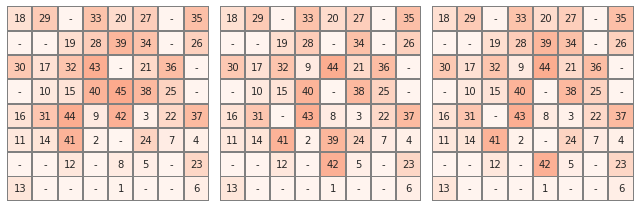

In [29]:
test = Matrix(top,rhs,bot,lhs)
test.solve()

In [13]:
url='https://www.janestreet.com/puzzles/solutions/august-2019-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The lowest possible product of the areas of the empty regions is 144 , which can be achieved in a few ways. (One is shown.)


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/09/20190831_knight_moves_3_sol.png" width="300" >